In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


(37229, 9)
Index(['Time', 'Class', 'Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C'], dtype='object')


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


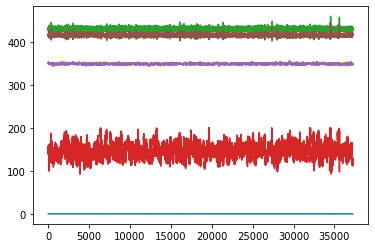

In [2]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
print(dfRaw.shape)
print(dfRaw.columns)


d=dfRaw.iloc[:,2:8]

plt.plot(d)
plt.show()

In [4]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")


data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0 %


[0.51899794 0.22757746 0.20203542]


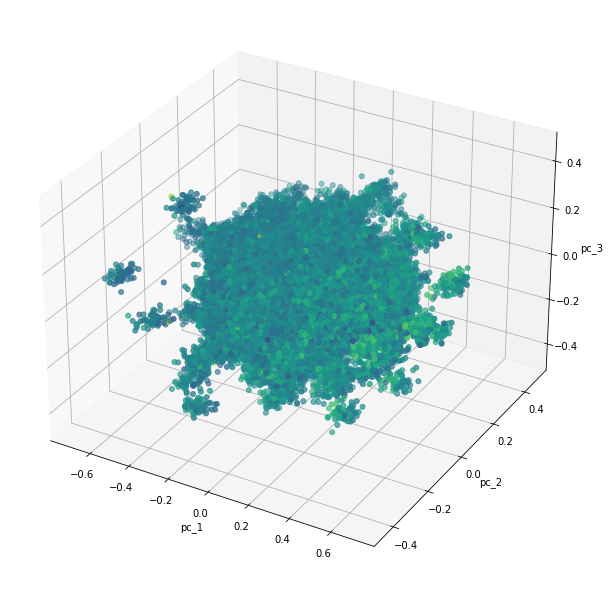

In [5]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def show_pca_df(df):

    
	x = df[df.columns[2:7]].to_numpy()
	y = df[df.columns[8]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)
    
	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

show_pca_df(df)





/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


             Ci          Ti           T          Qc         Tci          Tc  \
0      0.980425  350.161113  430.879955  148.172248  353.070651  416.808275   
1      0.982154  349.893811  430.954030  150.128467  352.898114  417.404921   
2      0.982740  350.400543  428.739400  140.741225  352.927981  416.268197   
3      0.981765  350.434309  431.848582  142.384731  353.204221  418.892574   
4      0.983645  349.964550  432.018687  149.025700  352.879206  418.205232   
...         ...         ...         ...         ...         ...         ...   
37224  0.930009  350.407842  431.390973  126.703313  349.320896  418.992018   
37225  0.927932  350.051108  430.872379  129.143257  349.021722  418.191519   
37226  0.928106  350.351510  427.776623  115.769767  349.445744  416.663481   
37227  0.928749  350.189041  433.307479  121.383223  349.340147  421.117491   
37228  1.010881  350.607754  431.535159  129.692051  347.489658  418.429683   

              C  
0      0.100791  
1      0.097220

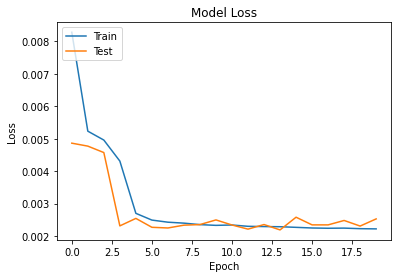

In [11]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing





df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()
print(df[df.columns[2:9]])
# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.2)

n_features = x.shape[1]

print(n_features)
# # model
encoder = keras.Sequential(name='encoder')
encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
encoder.add(keras.layers.Dropout(0.1))
encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

decoder = keras.Sequential(name='decoder')
decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
decoder.add(keras.layers.Dropout(0.1))
decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(
	loss=keras.losses.MSE,
	optimizer=keras.optimizers.Adam(),
	metrics=[keras.metrics.mean_squared_error])

# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=20, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
0.006781689589843144
0.002528287


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



MAE
18.03582344055176
7553.5254


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



MLE
0.003235876117832956
0.0011848964


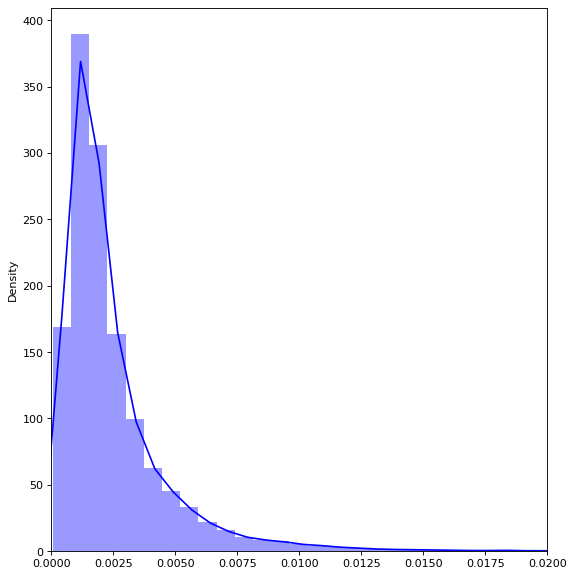

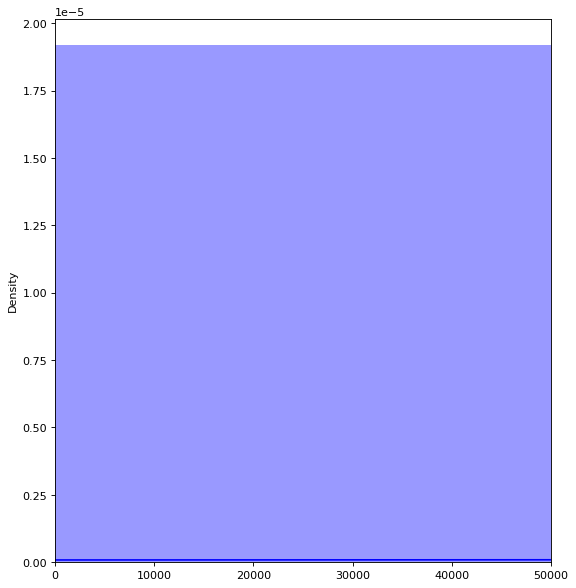

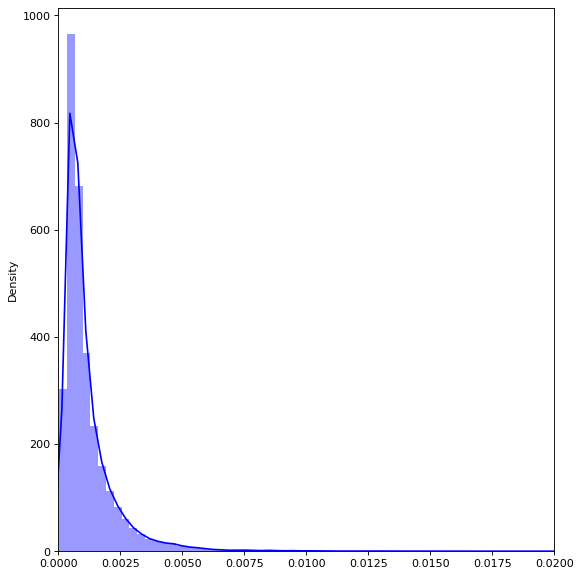

In [12]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))



# Mean Absolute error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mae = keras.losses.mean_absolute_percentage_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mae, 95)


# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mae, bins=2000, kde=True, color='blue')
plt.xlim([0., 50000]);


print('')
print('MAE')
print(cut_off)
print(np.average(train_events_mae.numpy()))


# Mean Log error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mle = keras.losses.mean_squared_logarithmic_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mle, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mle, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);

print('')
print('MLE')
print(cut_off)
print(np.average(train_events_mle.numpy()))



            Ci          Ti         C           T          Qc         Tci  \
0     1.030513  350.778527  0.099384  430.871209  148.814799  348.613714   
1     1.029564  351.255911  0.101274  430.910049  149.201249  348.280896   
2     1.028076  351.089261  0.102826  430.415965  146.385718  348.522685   
3     1.027996  351.399371  0.097840  431.518419  147.980219  348.537786   
4     1.029284  350.949416  0.093054  432.535963  156.651259  348.421418   
...        ...         ...       ...         ...         ...         ...   
1196  0.978220  349.732360  0.091048  432.097287  199.713339  350.140448   
1197  0.977618  349.310307  0.084909  433.985044  200.333432  350.338977   
1198  0.976726  349.876704  0.082744  434.426010  200.289803  350.519770   
1199  0.977003  349.574596  0.082439  434.626850  200.417551  350.709570   
1200  0.965837  350.278277  0.080900  434.972682  199.592563  347.787641   

              Tc  
0     416.838537  
1     416.193713  
2     415.976322  
3     417.2

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

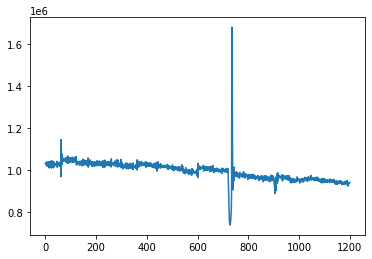

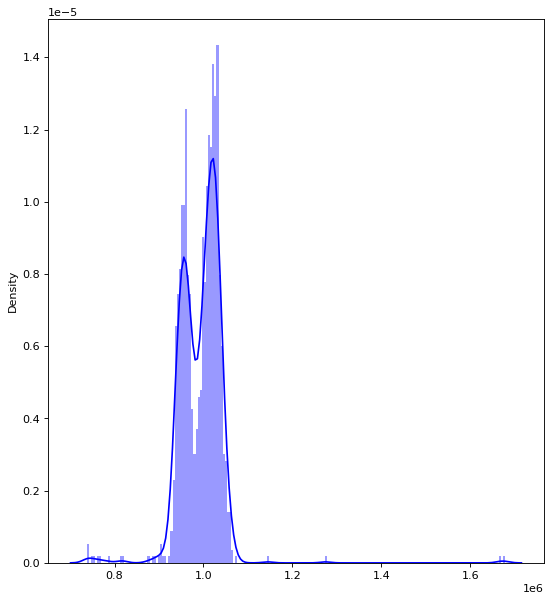

In [29]:
# Import dataset whihc has a fault to be detected

df = pd.read_excel('Fault 40.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)




plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()
print(df[df.columns[2:9]])
print(x.shape[1])
# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse})


Final=pd.DataFrame(abnormal_events_df.mse)

Final['cutoff']=0.001

print(Final)
plt.plot(abnormal_events_df.mse)


# abnormal_events_df.to_excel('test4.xlsx')


plt.figure(figsize=(8,9), dpi=80)
sns.distplot(abnormal_events_mse, bins=200, kde=True, color='blue')
;

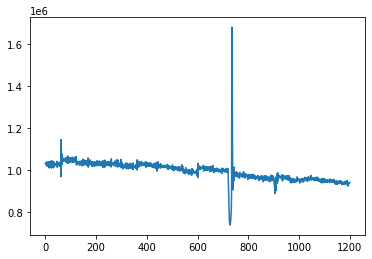

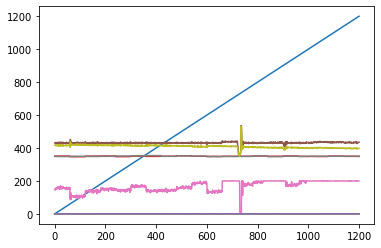

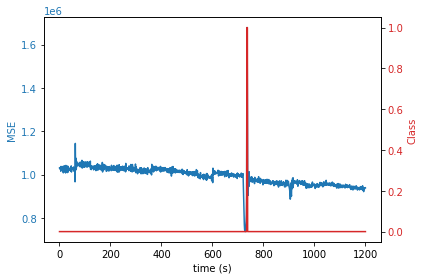

In [33]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Fault 40.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()